In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

import mu_avg.mu_avg as mu_avg

Welcome to JupyROOT 6.12/04


In [2]:
interp_df = pd.read_hdf('hdf5/super-long_stationary_run.h5', 'interp_df')

interp_df = interp_df[['tr'+str(i) for i in range(17)]]

probe_uncs = []

for probe in range(17):
    diffs = np.diff(interp_df['tr'+str(probe)])
    diffs = diffs - np.polyval(np.polyfit(range(len(diffs)), diffs, 2), range(len(diffs)))
    probe_uncs.append(np.std(diffs))

probe_uncs = np.array(probe_uncs)

In [3]:
print probe_uncs

[0.3860835  0.49323439 0.30195771 0.43885238 0.32305238 0.65923526
 0.33355068 0.34612728 0.37816046 0.41809956 1.36347138 0.55391086
 0.29641496 0.35260223 0.34906363 0.54585391 1.41715753]


In [4]:
def multipole(order, skew, strength, x_pos, y_pos):
    """Returns the magnitude of a B-field given multipole parameters
    and position.
    """
    # Takes a multipole strength A normalized to 4.5 cm
    r_pos = np.sqrt(x_pos**2 + y_pos**2)
    theta = np.arctan2(y_pos, x_pos)
    if skew == 0:
        b_magnitude = strength * (r_pos/4.5)**order * np.cos(order*theta)
    if skew == 1:
        b_magnitude = strength * (r_pos/4.5)**order * np.sin(order*theta)
    return b_magnitude

all_ns =    [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 10, 12]
all_skews = [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


In [5]:
mults = np.array([multipole(all_ns[i], all_skews[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(len(all_ns))])
mults[np.abs(mults) < 1.0e-9] = 0

theta_tr_all = np.linalg.pinv(np.transpose(mults))
theta_tr_all[np.abs(theta_tr_all) < 1.0e-9] = 0

test_m = np.matmul(theta_tr_all, np.transpose(mults))
test_m[np.abs(test_m) < 1.0e-4] = 0
print np.round(test_m,2)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [10]:
chi2s = []

through = 16

for fit_order in range(1,through+1):

    # make a theta_tr matrix using only a set number of multipoles

    ns = all_ns[0:fit_order]
    skews = all_skews[0:fit_order]

    mults = np.array([multipole(ns[i], skews[i], 1, trfp.TR_X, trfp.TR_Y) for i in range(fit_order)])
    mults[np.abs(mults) < 1.0e-9] = 0

    theta_tr = np.linalg.pinv(np.transpose(mults))
    theta_tr[np.abs(theta_tr) < 1.0e-9] = 0

    # run a set of trolley probe measurements through the matrix

    meas = interp_df.iloc[20000].values

    fit_coeffs = np.matmul(theta_tr, meas)

    fit_values = np.zeros(17)
    for i in range(fit_order):
        fit_values += multipole(ns[i], skews[i], fit_coeffs[i], trfp.TR_X, trfp.TR_Y)

    resids = meas - fit_values
    
    probe_uncs = np.full(17, 3)

    chi2 = 0
    for i in range(17):
        chi2 += resids[i]**2/probe_uncs[i]**2

    chi2s.append(chi2)
    
chi2s = np.array(chi2s)
dof = np.array([17 - m for m in range(1,through+1)])
dof_Nm1 = np.array([17 - m - 1 for m in range(1,through)])
print chi2s
print chi2s/dof
F_chi = (chi2s[:-1] - chi2s[1:])/(chi2s[1:]/dof_Nm1)

[33028.12766088 32849.70868391 23187.38636979  9616.96099266
  9550.5249507   7346.00072514  7166.78736439  7024.53602157
  2226.54122597  2101.45825064  2092.54638724   221.61283936
   221.15335875   215.03735752   154.92289842    64.10356816]
[2064.25797881 2189.98057893 1656.24188356  739.7662302   795.87707923
  667.81824774  716.67873644  780.5040024   278.31765325  300.20832152
  348.75773121   44.32256787   55.28833969   71.67911917   77.46144921
   64.10356816]


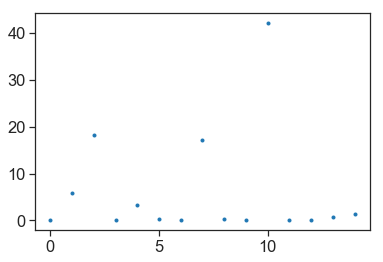

In [7]:
plt.plot(F_chi, '.')